# Simulation of NBR03 with updated NBRsimulator package

In [1]:
from ResSimulator import NBResonator

In [2]:
from TrappingSimulator import QPtrapper

In [3]:
savepath = r"D:\James\NBR03simulation\\"

## definition of parameters used in QP trapper

In [4]:
duration = 0.01 # seconds to record data
sampleRate = 300e6
N = int(duration*sampleRate)
tauTrap = 140e-6
tauRelease = 100e-6
tauCommon = 4e-4
tauRare = 7e-1
tauRecomb = 2e-4
phi = 0.4
Lj = 21.2e-12 # squid inductance at zero phase bias
args = {'N':N,'Lj':Lj,'tauTrap':tauTrap,'tauRelease':tauRelease,'tauCommon':tauCommon,'tauRare':tauRare,
        'tauRecomb':tauRecomb,'sampleRate':sampleRate,'phi':phi,'Delta':2.72370016e-23,'T':0.010}

In [5]:
trapper = QPtrapper(**args)

## Now we have the trapping events, let's generate the resonator response. define some more parameters

In [6]:
L = 1.89e-9
C = 0.2776e-12
Qi = 6000
Qe = 500
photonRO = 100
delKappa = -0.1

resArgs = {'L':L,'C':C,'photonRO':photonRO,'Qi':Qi,'Qe':Qe,'sampleRate':sampleRate,'delKappa':delKappa}

res = NBResonator(trapper,**resArgs)

In [7]:
res.dParams

{'fd': 6824061054.380685,
 'f0': 6825539921.3636465,
 'Qt': 461.53846153846155,
 'Qi': 6000,
 'Qe': 500,
 'N': 3000000,
 'q': 0.011092507325240687,
 'photonRO': 100,
 'sampleRate': 300000000.0,
 'kappa': 92919952.98620617,
 'fwhm': 14788669.829621233,
 'diameter': 1.8461538461538463,
 'freq_shift': 132091.7367872781,
 'SNR': 8.38860686681028,
 'SNRdB': 9.236898416041372,
 'sigma': 0.34526700632174206}

## start some analysis with integration for desired SNR

In [8]:
from scipy.constants import pi
from scipy.signal import windows, convolve
avgTime50 = 4*res.dParams['Qt']*50/(res.dParams['photonRO']*2*pi*res.dParams['f0'])
avgTime100 = 4*res.dParams['Qt']*100/(res.dParams['photonRO']*2*pi*res.dParams['f0'])
avgTime500 = 4*res.dParams['Qt']*500/(res.dParams['photonRO']*2*pi*res.dParams['f0'])
print('integrate for {} us for RF power SNR=50'.format(avgTime50*1e6))
print('integrate for {} us for RF power SNR=500'.format(avgTime500*1e6))

integrate for 0.021523902409818232 us for RF power SNR=50
integrate for 0.21523902409818232 us for RF power SNR=500


### actual integration time used in measurement analysis was 5 microseconds, so match that

In [9]:
nAvg = int(max(5e-6*res.dParams['sampleRate'],1))
window = windows.hann(nAvg)
rhann = convolve(res.signal.real,window,mode='same')/sum(window)
ihann = convolve(res.signal.imag,window,mode='same')/sum(window)

### Plot a segment as time series for visual

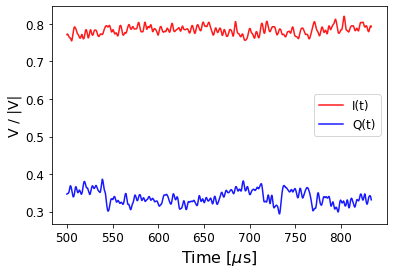

In [10]:
import matplotlib.pyplot as plt
import numpy as np
time = np.arange(res.dParams['N'])/res.dParams['sampleRate']

h = plt.subplot()
h.plot(time[150000:250000]*1e6,rhann[150000:250000],'r',alpha=0.9,label='I(t)')
h.plot(time[150000:250000]*1e6,ihann[150000:250000],'b',alpha=0.9,label='Q(t)')
h.set_xlabel('Time [$\mu$s]',fontsize = 16)
h.set_ylabel('V / |V|',fontsize = 14)
h.tick_params(labelsize=12)
h.legend(fontsize=12)
plt.savefig(savepath+r'NBR03noisySignal_SNR50.svg',format='svg')
plt.show()

### plot complex histogram

In [11]:
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm

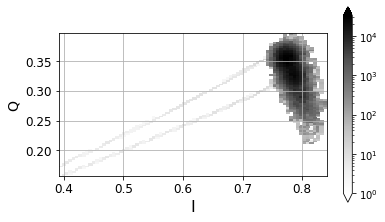

In [12]:
h = plt.subplot()
hs = plt.hist2d(rhann,ihann,bins=(80,80),norm=LogNorm(),cmap=plt.get_cmap('Greys'))
hb = plt.colorbar(hs[-1], shrink=0.9, extend='both')
h.set_aspect('equal')
h.grid()
h.set_xlabel('I',fontsize=16)
h.set_ylabel('Q',fontsize=14)
h.tick_params(labelsize=12)
plt.savefig(savepath+r'NBR03hist.svg',format='svg')
plt.show()

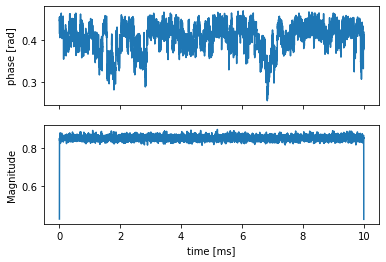

In [13]:
h,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(time*1e3,np.arctan(ihann/rhann))
ax[0].set_ylabel('phase [rad]')
ax[1].plot(time*1e3,np.sqrt(rhann**2 + ihann**2))
ax[1].set_ylabel('Magnitude')
ax[1].set_xlabel('time [ms]')
plt.savefig(savepath+r'NBR03magphase.svg',format='svg')
plt.show()